# Predicting Coronary Heart Disease from Non-Invasive Data

**This final project performs feature reduction using recursive feature elimination and fits a logistic regression classification model on the Cleveland Clinic Heart Disease Dataset. The dataset was obtained from Kaggle.com at https://www.kaggle.com/datasets/aavigan/cleveland-clinic-heart-disease-dataset. The purpose is to predict coronary heart disease (CHD) from non-invasive diagnostic test data and patient characteristics. Succesfully meeting this goal could one day replace the highly invasive diagnostic test, coronary angiography. A detailed data dictionary can be found at the aforementioned Kaggle url.**

#### Load libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')

#### Import & Clean Data

In [2]:
# read the csv file,  set variables to categorical, replace special characters with na
dt = {x:'category' for x in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']}
df = pd.read_csv('processed_cleveland.csv', dtype=dt, na_values = '?')

# recode the target variable 'num' as 'negative' (no CHD) and 'positive' (CHD present)
df['num'] = df['num'].replace({x : ('negative' if x < 1 else 'positive') for x in range(0, 5)})
df.dropna(inplace = True) 
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6,negative
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3,positive
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7,positive
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3,negative
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3,negative


## Exploratory Data Analysis
Distributions and summary statsitics on each column are in the Pandas Profiling Report, 'report.html', created by the commented code below. The subjects of this study are generally unhealthy with most having high cholesterol and high blood pressure, and many have enlarged hearts with electrical abnormalities and calcified blood vessels.

In [3]:
# design_report = ProfileReport(df)
# design_report.to_file(output_file='report.html')

## Prepare Data for Modelling

#### Scale variables to mean = 0, sd = 1

In [4]:
df.loc[:, df.select_dtypes(include=['float', 'int']).columns] = \
    df.select_dtypes(include=['float', 'int']).apply(lambda x: (x - x.mean()) / x.std())

#### Create train and test data

In [5]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(df.loc[:, df.columns != 'num'], df.loc[:,'num'], test_size = .2, random_state = 42)

## Feature reduction using Recursive Feature Elimination (RFE) and K-fold Cross Validation (CV).

In [6]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression as LR

In [7]:
min_features_to_select = 1
clf = LR()
cv = StratifiedKFold(5)

rfecv = RFECV(estimator = clf, \
              step = 1, \
              cv=cv, \
              scoring='accuracy', \
              min_features_to_select=min_features_to_select, \
              n_jobs=2)
rfecv.fit(X_train,y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 9


#### Plot features Vs. accuracy for sensibility check

<IPython.core.display.Javascript object>


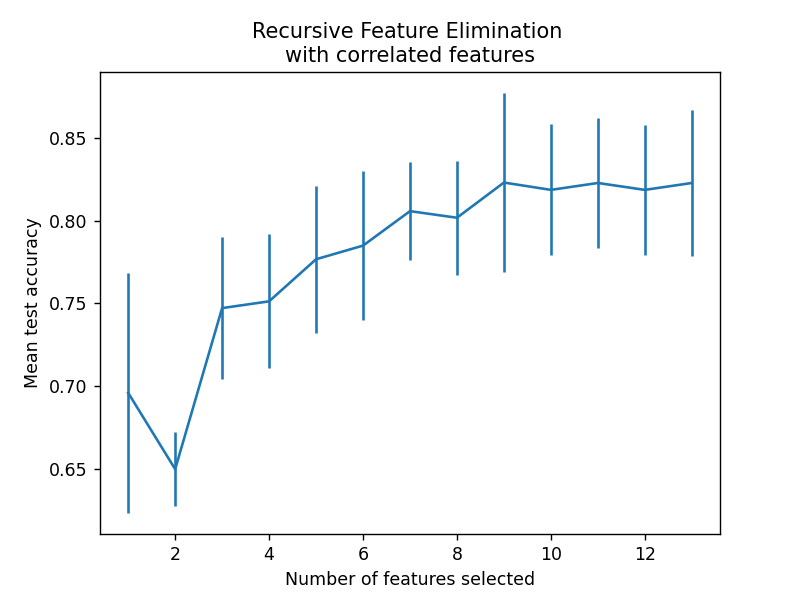

In [8]:
from matplotlib import pyplot as plt
%matplotlib notebook
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(range(1, n_scores + 1), \
             rfecv.cv_results_["mean_test_score"], \
             yerr=rfecv.cv_results_["std_test_score"],)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## Identify the 9 best features using RFE on training data.

In [9]:
from sklearn.feature_selection import RFE as rfe
selector = rfe(clf, n_features_to_select = 9)
selector = selector.fit(X_train, y_train)
X_train_red = selector.transform(X_train)
X_test_red = selector.transform(X_test)
predictors = list(X_train.columns[selector.support_])
predictors

['sex', 'cp', 'trestbps', 'fbs', 'thalach', 'exang', 'oldpeak', 'slope', 'ca']

# Fit & evaluate LR model using final predictors

#### Fit logisitic regression to training data

In [10]:
from sklearn.linear_model import LogisticRegression as LR

LogReg = LR(class_weight = 'balanced', solver = 'liblinear').fit(X_train_red, y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

#### Evaluate LR model on test data

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, \
f1_score, precision_score, recall_score, roc_auc_score

# transform outcome variable to array of integers (0,1)
y_test_num = y_test.replace({'negative' : 0, 'positive':1}).to_numpy()

# Generate predictions from test data as array of integers (0,1)
y_pred = LogReg.predict(X_test_red)
y_pred = pd.Series(y_pred).replace({'negative':0, 'positive':1}).to_numpy()

# Performance metrics
print('Confusion Matrix:\n', confusion_matrix(y_test_num, y_pred))
print('Accuracy:', round(accuracy_score(y_test_num, y_pred), 3))
print('F score:', round(f1_score(y_test_num, y_pred), 3))
print('Recall:', round(recall_score(y_test_num, y_pred), 3))
print('Precision:', round(precision_score(y_test_num, y_pred), 3))
print('ROC AUC:', round(roc_auc_score(y_test_num, y_pred), 3))

Confusion Matrix:
 [[29  7]
 [ 7 17]]
Accuracy: 0.767
F score: 0.708
Recall: 0.708
Precision: 0.708
ROC AUC: 0.757


## Classificaiton performance summary

The performance metrics reveal that logistic regression performed with an accuracy of about 77%, a harmonic mean of precision and recall (F Score) equal to 71%, comparable precision and recall of 71% and an ROC area under the curver of 76%. While coronary angiography may still have better performance, the results of this study suggest that logistic regression on non-invasive diagnostic data can perform well and may have value as a low cost, non-invasive assessment for low risk individuals or individuals for whom coronary angiography is particuarly dangerous.

# Fit a final model using all data 

To obtain the most accurate coefficients for making inferrences, a final model is fit to all of the data using the hyperparameter identified by cross validation (d = 9) and the specific predictors identified on the training data. The data used are unscaled to aide interpretation of coefficients. 

In [12]:
# import and clean data
import statsmodels.formula.api as sm

dt = {x:'category' for x in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']}
df = pd.read_csv('processed_cleveland.csv', dtype=dt, na_values = '?')
df['num'] = df['num'].replace({x : (0 if x < 1 else 1) for x in range(0, 5)})
df.dropna(inplace = True) 

# Final model fit and summary
lrm = sm.logit(formula = 'num ~ sex + cp + trestbps + fbs + thalach + exang + oldpeak + slope + ca', data = df)
fit1 = lrm.fit()
fit1.summary()

Optimization terminated successfully.
         Current function value: 0.349755
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    num   No. Observations:                  297
Model:                          Logit   Df Residuals:                      284
Method:                           MLE   Df Model:                           12
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.4932
Time:                        20:43:57   Log-Likelihood:                -103.88
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 1.150e-36
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0827      2.254     -2.698      0.007     -10.501      -1.665
sex[T.1]       1.8984      0.440      4.313      0.000       1.036       2.761
cp[T.2]        1.0885      0.732      1.488      0.137      -0.345       2.522
cp[T.3]        0.2875      0.639      0.450      0.653      -0.964       1.539
cp[T.4]        2.1654      0.630      3.436      0.001       0.930       3.401
fbs[T.1]      -0.6588      0.559     -1.178      0.239      -1.755       0.438
exang[T.1]     0.8832      0.419      2.110      0.035       0.063       1.704
slope[T.2]     1.3028      0.447      2.915      0.004       0.427       2.179
slope[T.3]     0.5327      0.866      0.615      0.539      -1.165       2.230
trestbps       0.0273      0.010      2.646      0.008       0.007       0.047
thalach       -0.0151      0.010     -1.553      0.121      -0.034       0.004
oldpeak        0.3813      0.212      1.802      0.072      -0.034       0.796
ca             1.2646      0.252      5.026      0.000       0.771       1.758
==============================================================================
"""

## Inferrences from final model.
A few of the statistically significant coefficients are interpreted below:

1) Males have nearly 7 fold greater CHD odds than females. 

In [13]:
print('Sex OR estimate:', round(np.exp(1.8984), 1))
print('low:', round(np.exp(1.036), 1))
print('high:', round(np.exp(2.761), 1))

Sex OR estimate: 6.7
low: 2.8
high: 15.8


2) For every additional calcified coronary vessels present, the odds of CHD increases by about 3.5 fold.

In [14]:
print('ca OR estimate:', round(np.exp(1.2646), 1))
print('low:', round(np.exp(0.771), 1))
print('high:', round(np.exp(1.758), 1))

ca OR estimate: 3.5
low: 2.2
high: 5.8


3) Compared to angina chest pain, asymptomatic chest pain (silent myocardial ischemia) involves a nearly 9-fold increase in the odds of CHD.

In [15]:
print('cp OR estimate:', round(np.exp(2.1654), 1))
print('low:', round(np.exp(0.930), 1))
print('high:', round(np.exp(3.401), 1))

cp OR estimate: 8.7
low: 2.5
high: 30.0
